# Textract demo

First we import the modules

In [1]:
import boto3
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import io
from io import BytesIO
import IPython
from IPython.display import JSON
import json
from IPython.display import display
import urllib.request
import pandas as pd


### Bounding box function

We use this to draw bounding boxes around the objects we detect

In [2]:
def makeBoundingBoxes(image, blocks, maxboxes=10):
    #image = Image(imageData)
    draw = ImageDraw.Draw(image) 
    imgWidth, imgHeight = image.size  
    for block in blocks:
        #print(json.dumps(block, indent=2))
        labelname = block.get("Text", block["BlockType"])
        #labelconfidence = block["Confidence"]
        
        #for instance in labelDetail["Instances"]:  
            #print("-----------------\n\n****", labelname, " confidence = ", labelconfidence)
            #print(json.dumps(instance, indent=2))            
        box = block['Geometry']['BoundingBox']
        left = imgWidth * box['Left']
        top = imgHeight * box['Top']
        width = imgWidth * box['Width']
        height = imgHeight * box['Height']

        points = (
            (left,top),
            (left + width, top),
            (left + width, top + height),
            (left , top + height),
            (left, top)

        )
        draw.line(points, fill='#00d400', width=2)  
        fnt = ImageFont.load_default().font  
        draw.text((left , top), labelname, font = fnt, align ="left", fill='#00d400')            
    #display(image)
    return image


### Read image from as bytes

For the demo we will directly pull images from web locations. In real implementations we are more likely to read from S3, which is also supported

In [3]:
def getImageAsBytes(imageurl):
    imagedata = urllib.request.urlopen(imageurl).read()
    return imagedata 


## Here we invoke Textract to detect the text in an image (***)

We use this method, but there are others you can use as well.

https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/textract.html#Textract.Client.detect_document_text

In [19]:
def detect_document_text(imageurl):
    imageasbytes = getImageAsBytes(imageurl)
    client = boto3.client('textract')
    response = client.detect_document_text(
        Document={
            'Bytes': imageasbytes
        }
    )
    #print(response)
    return response["Blocks"]

### putting it all together. This is where we invoke the functions above 

In [5]:
imageurl = "https://upload.wikimedia.org/wikipedia/commons/7/75/Avalon_Drawing.jpg"
imageurl = "https://upload.wikimedia.org/wikipedia/commons/e/e6/Avrocar_schematic_%28high_resolution%29.jpg"
#imageurl = "https://upload.wikimedia.org/wikipedia/en/0/04/Spiralift_Patent.jpg"
mydata = getImageAsBytes(imageurl)
#display(IPython.display.Image(data=mydata))
stream = io.BytesIO(mydata)
img = Image.open(stream)

### You can view the output here as Json format

In [6]:

documentTextBlocks = detect_document_text(imageurl)
JSON(documentTextBlocks)

<IPython.core.display.JSON object>

### We create the bounding boxes and display this in the image

In [7]:


newimage = makeBoundingBoxes(img, documentTextBlocks, maxboxes=10)


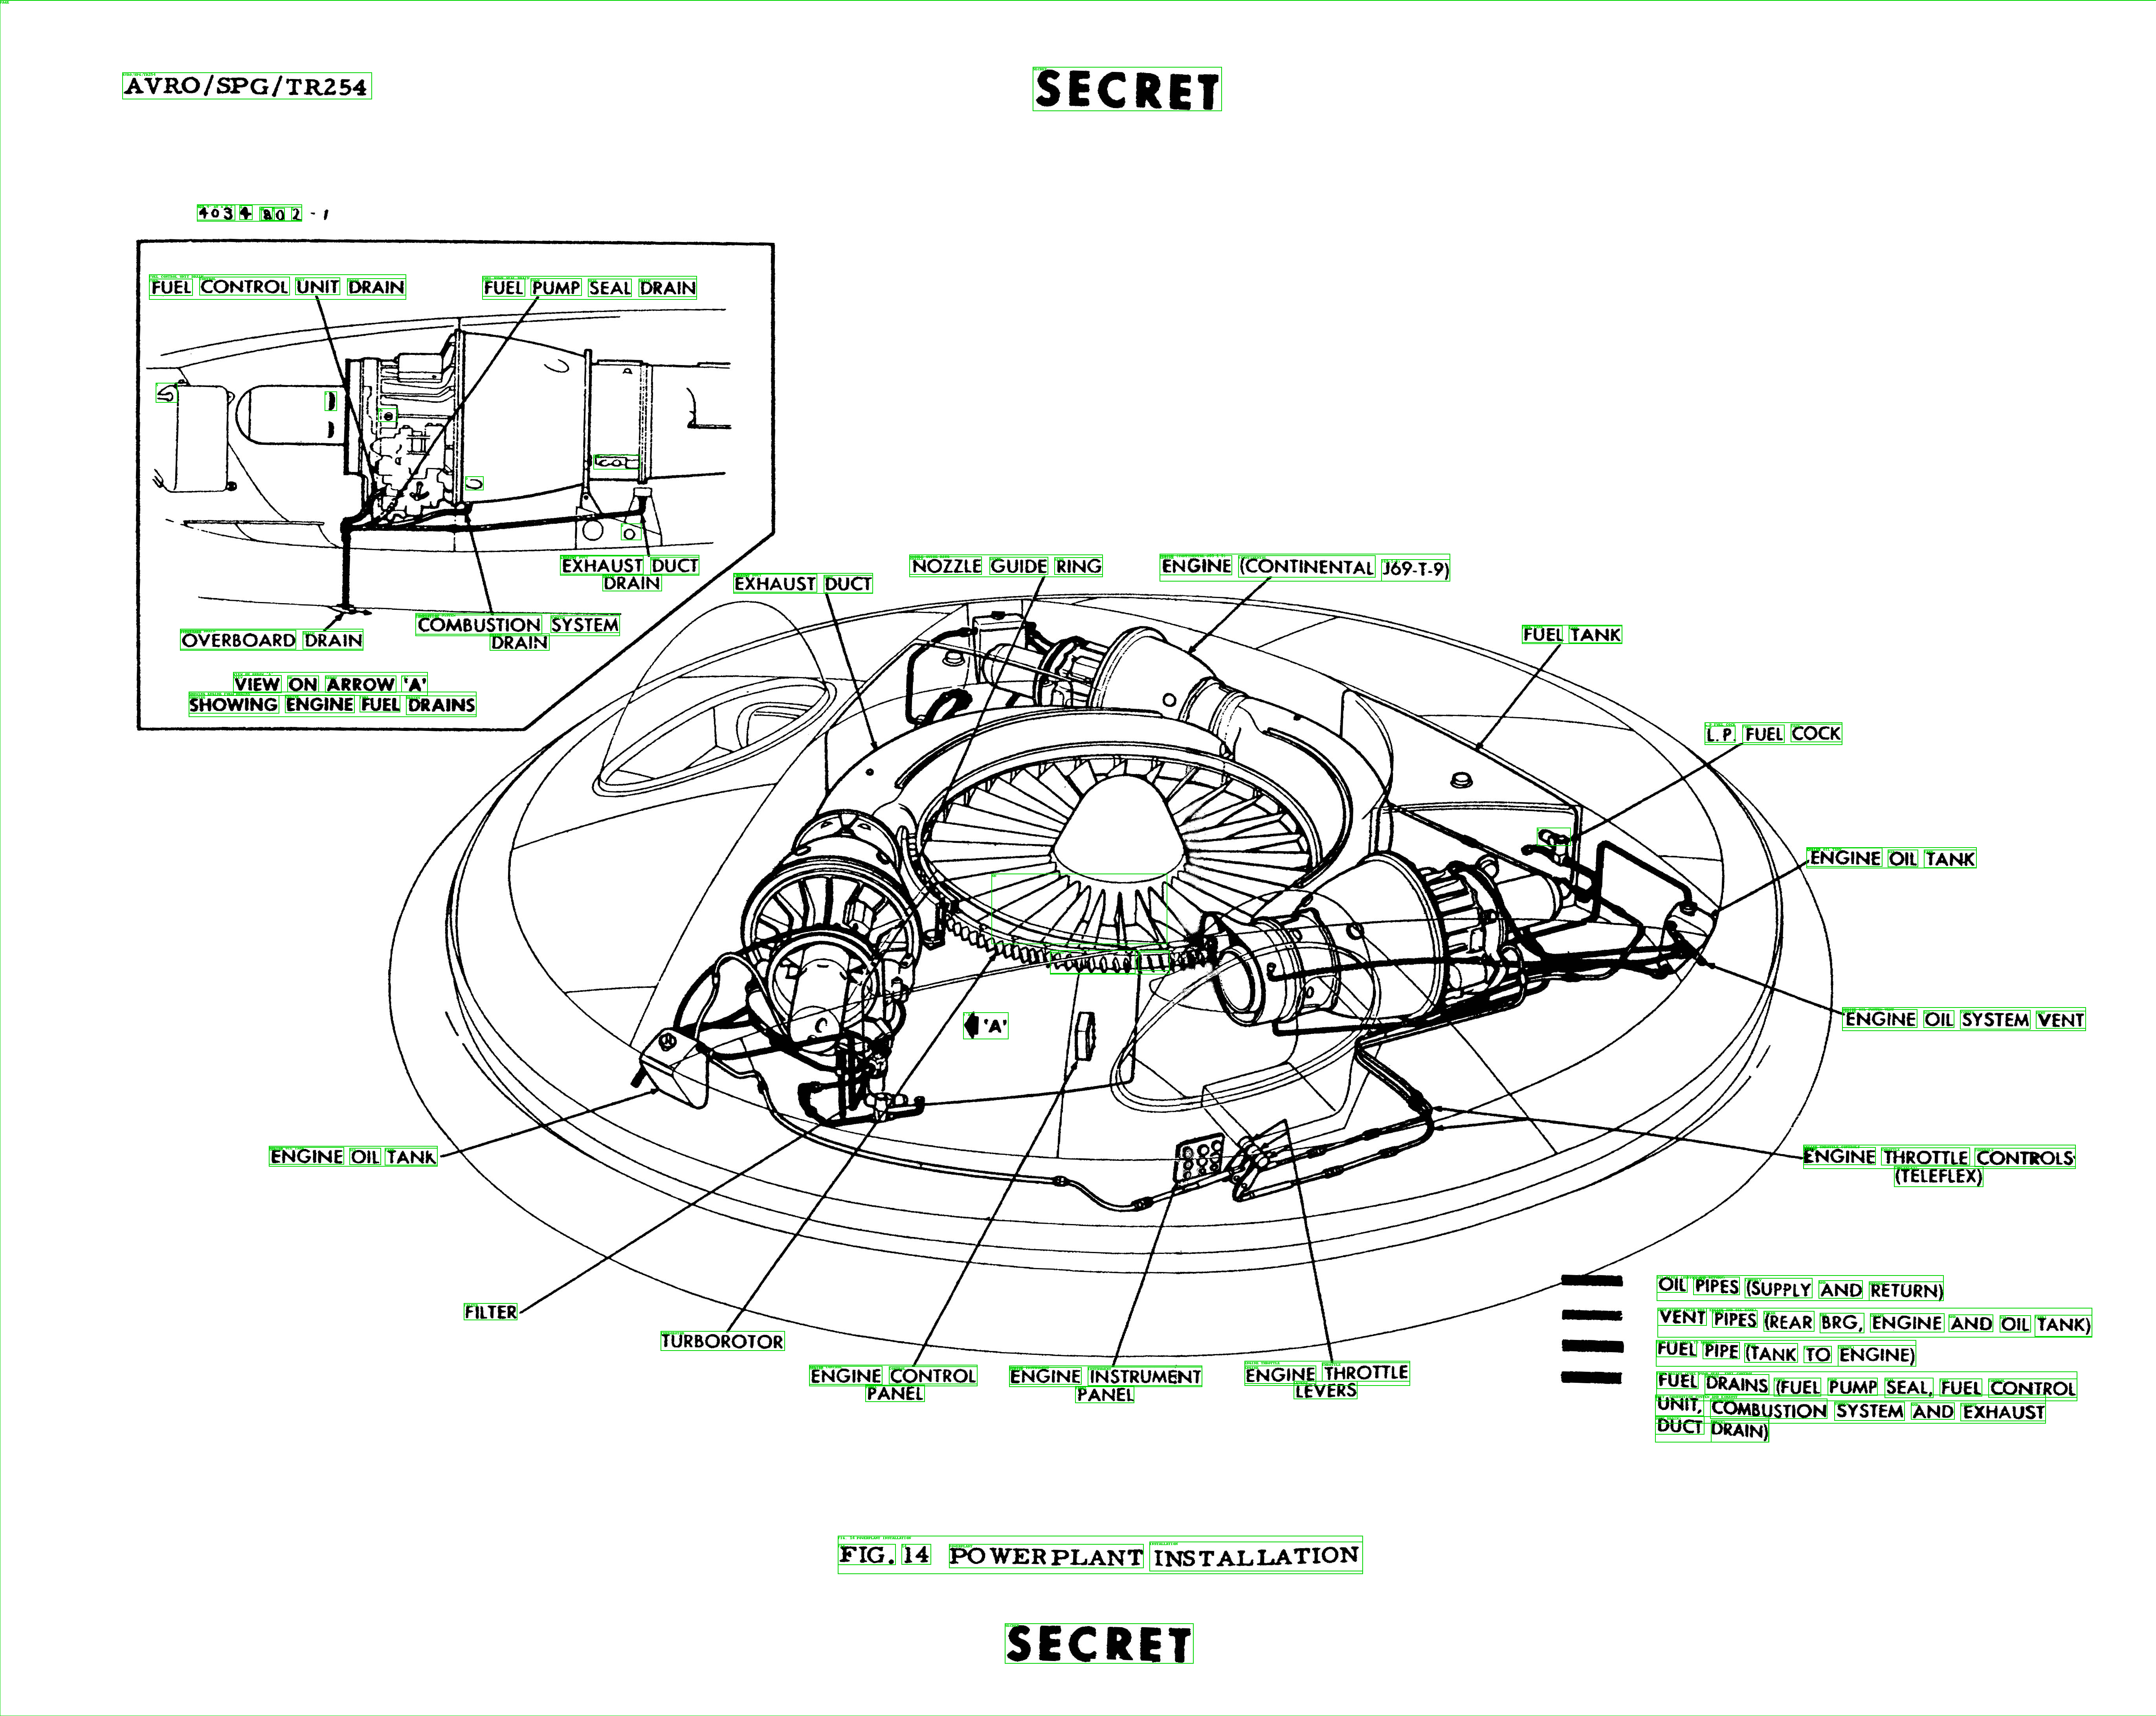

In [8]:
display(newimage)

# Now we will use Textract to analyze documents in terms of tables or Forms (***)

Here is the method that we will use: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/textract.html#Textract.Client.analyze_document

We send the image as bytes, but we could have just as easily passed the S3 location of the image or doc.

In [9]:
def analyze_document(imageurl, featureTypes=['TABLES']):
    imageasbytes = getImageAsBytes(imageurl)
    client = boto3.client('textract')
    response = client.analyze_document(
        Document={
            'Bytes': imageasbytes
        },
        FeatureTypes=featureTypes
    )
    #print(json.dumps(response))
    return response["Blocks"]

In [10]:

#imageurl = "https://github.com/dupled3031/AWS-AIML-examples/raw/master/media/images/world-economy.png"
imageurl = "https://github.com/dupled3031/AWS-AIML-examples/raw/master/media/images/Canada-economy.png"
analyzeDocBlockResults = analyze_document(imageurl) 
#print(json.dumps(analyzeDocBlockResults, indent=2))
mydata = getImageAsBytes(imageurl)
#display(IPython.display.Image(data=mydata))
stream = io.BytesIO(mydata)
img = Image.open(stream)

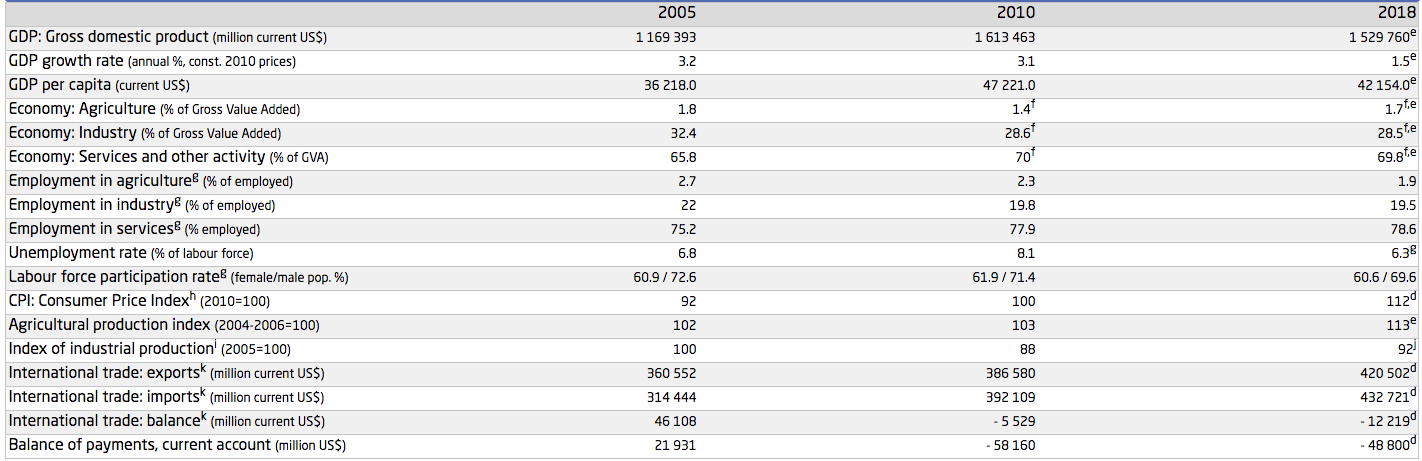

In [11]:
mydata = getImageAsBytes(imageurl)
display(IPython.display.Image(data=mydata))

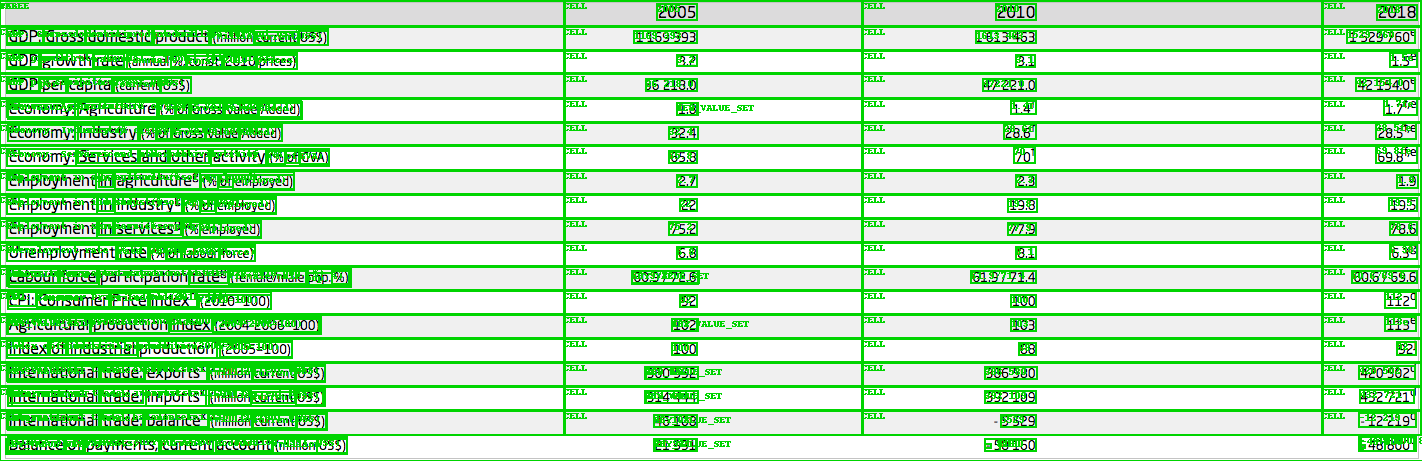

In [12]:
newimage = makeBoundingBoxes(img, analyzeDocBlockResults, maxboxes=10)
display(newimage)

In [13]:
JSON(analyzeDocBlockResults)




<IPython.core.display.JSON object>

In [14]:
def getBlockValueByid(blockresults, id):
    value = ""
    for item in blockresults:
        if item["Id"] == id:
            return item["Text"]
    
    return value 

def getDataFrameFromBlockResults(blockresults):
    datalist = []
    rows = 0
    columns = 0
    for item in blockresults:
        if item["BlockType"] == "CELL":
            for relationship in item.get("Relationships",[]):
                #print(relationship)
                for thisid in relationship["Ids"]:
                    #print("thisid: ", thisid)
                    thisvalue = getBlockValueByid(blockresults, thisid)
                    thisobject = {"RowIndex": item["RowIndex"], "ColumnIndex": item["ColumnIndex"], "Text": thisvalue}
                    rows = max(rows, item["RowIndex"])
                    columns = max(columns, item["ColumnIndex"])
                    datalist.append(thisobject)
    newdataList = []
    for rowid in range(0, rows+1):
        newrowlist = []
        for colid in range(0, columns+1):
            thisvalue = ""
            for item in datalist:
                if item["RowIndex"] == rowid and item["ColumnIndex"] == colid:
                    if thisvalue == "":
                        thisvalue = item["Text"]
                    else:
                        thisvalue += " " + item["Text"]
            newrowlist.append(thisvalue)
        newdataList.append(newrowlist) 
    df = pd.DataFrame(newdataList)
    return df


In [15]:
mydata = getDataFrameFromBlockResults(analyzeDocBlockResults)            
print(mydata)

   0                                                  1          2          3  \
0                                                                               
1                                                             2005       2010   
2     GDP: Gross domestic product (million current USS)   1169 393   1613 463   
3         GDP growth rate (annual %, const 2010 prices)        3.2        3.1   
4                          GDP per capita (current USS)   36 218.0    47221.0   
5         Economy: Agriculture (% of Gross Value Added)        1.8       1.4T   
6            Economy: Industry (% of Gross Value Added)       32.4      28.6f   
7       Economy: Services and other activity (% of GVA)       65.8         70   
8            Employment in agricultures (% of employed)        2.7        2.3   
9               Employment in industrys (% of employed)         22       19.8   
10                  Employment in services (% employed)       75.2       77.9   
11                Unemployme

![title](Textract-ref-architecture1.png)


![title](Textract-ref-architecture2.png)

![title](Textract-ref-architecture3.png)